<img src="img/fib.png" alt="SVDS" width="300" align="left">

# *James Doone* 
## Applied Time Series Econometrics in Python

Thanks to Jeffrey Yau and his team of data scientists.


### 1.1 Model selection heuristics

ARIMA $(p,d,q)$

SARIMAX $(p,d,q) \times (P,D,Q)_{s}$

- Examine the time series to understand its characteristics, e.g., trend, seasonality.
- Choose an appropriate model form (ARIMA, SARIMA, ARIMAX, SARIMAX).
- Check for (unit root) stationarity of the time series.
  - Determine whether differencing (informs $d$ and $D$) or other transformation is necessary to make stationary.
- Examine ACF and PACF to determine the initial choice of the AR($p$) and MA($q$) model orders, and seasonal $P$ and $Q$ orders if appropriate.
- Alternatively, or in addition, fit many models.
- Choose a model based on:
  - A criterion, e.g., AIC, BIC
  - Examination of statistical tests on residuals.
  - Out-of-sample forecast error.

<div class = "alert alert-danger">
$Load$ $Libraries$
</div>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

from __future__ import absolute_import, division, print_function

import sys
import os

import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

import itertools
import warnings

# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

/Users/jimdoone/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<div class = "alert alert-info">
$Load$ $and$ $Evaluate$ $Data$
</div>

In [30]:
df = pd.read_excel("Datasets_Udemy/Wallmart.xls", index_col=0)
df.head(1)

,Ridership ('000),Lag 1,detrend,lag 12,deseasonalize,lag(deseasonalize),"detrend, deseasonalize"
Month,,,,,,,
1991-01-01,1708.91700,nan,nan,nan,nan,nan,nan


In [31]:
ts = df.iloc[:-1, 0:1]

In [32]:
#ts['Month'] = ts['Month'].dt.strftime("%Y-%b")
ts.head(1)

,Ridership ('000)
Month,
1991-01-01,1708.91700


In [21]:
#ts.set_index('Month', drop=True, inplace=True)

In [33]:
# Examine the basic structure of the data
print("Data shape:", ts.shape, "\n")
print("First 5 observations of the data series:", "\n", ts.head())
print("Last 5 observations of the data series:", "\n", ts.tail())

Data shape: (159, 1) 

First 5 observations of the data series: 
             Ridership ('000)
Month                       
1991-01-01        1708.91700
1991-02-01        1620.58600
1991-03-01        1972.71500
1991-04-01        1811.66500
1991-05-01        1974.96400
Last 5 observations of the data series: 
             Ridership ('000)
Month                       
2003-11-01        2076.05400
2003-12-01        2140.67700
2004-01-01        1831.50800
2004-02-01        1838.00600
2004-03-01        2132.44600


<div class = "alert alert-info">
$Training$ $and$ $Test$ $Set$
</div>

In [34]:
n_sample = df.shape[0]

# Create a training sample and testing sample before analyzing the series

n_train=int(0.95*n_sample)+1
n_forecast=n_sample-n_train
#ts_df
ts_train = ts_df.iloc[:n_train]['value']
ts_test = ts_df.iloc[n_train:]['value']
print(ts_train.shape)
print(ts_test.shape)
print("Training Series:", "\n", ts_train.tail(), "\n")
print("Testing Series:", "\n", ts_test.head())


NameError: name 'ts_df' is not defined

<div class = "alert alert-info">
$Timeseries$ $Plot$
</div>

In [35]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

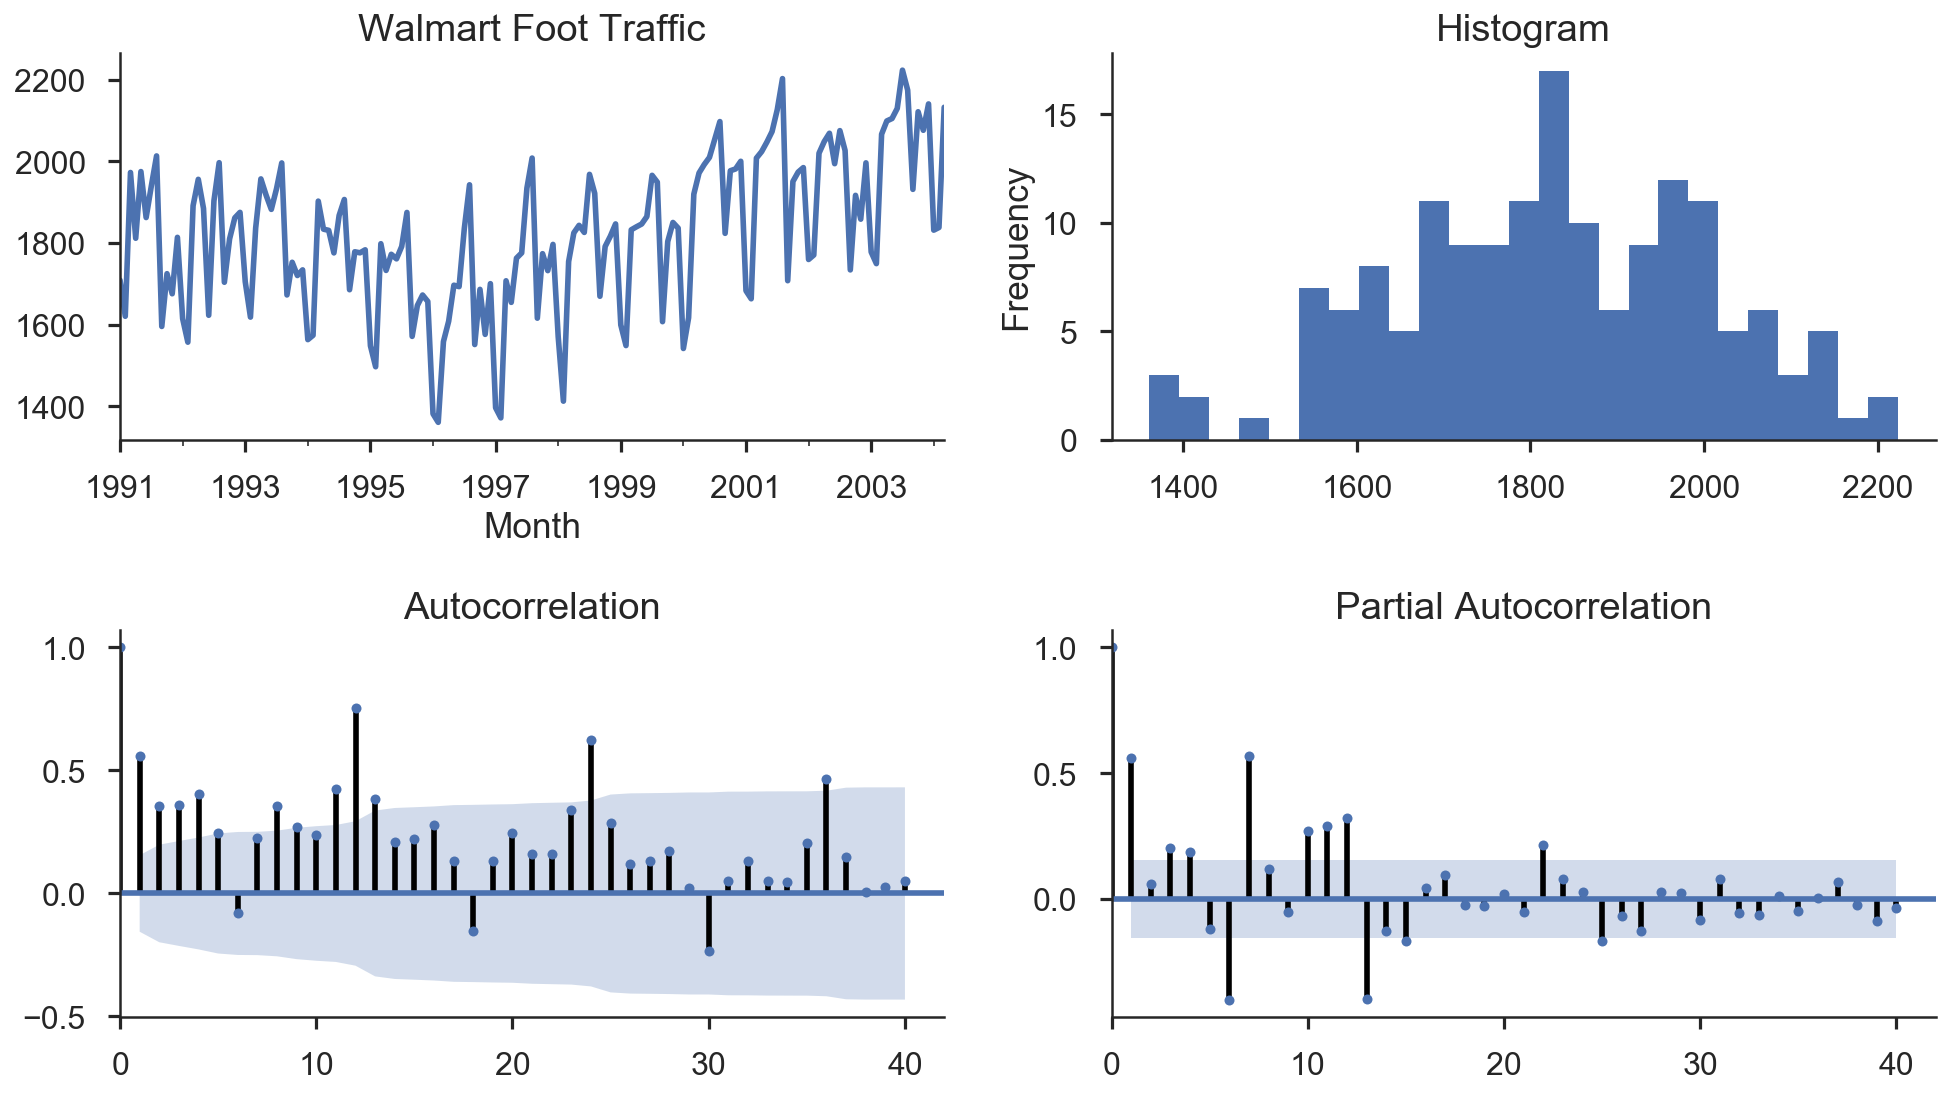

In [36]:
tsplot(ts["Ridership ('000)"], lags=40, title='Walmart Foot Traffic', figsize=(14, 8));

<div class="alert alert-info">
$Augmented$  $Dickey-Fuller$ $ (ADF) $
</div>

In [37]:
def test_stationarity(timeseries,
                      maxlag=None, regression=None, autolag=None,
                      window=None, plot=False, verbose=False):
    '''
    Check unit root stationarity of time series.
    
    Null hypothesis: the series is non-stationary.
    If p >= alpha, the series is non-stationary.
    If p < alpha, reject the null hypothesis (has unit root stationarity).
    
    Original source: http://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    
    Function: http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.stattools.adfuller.html
    
    window argument is only required for plotting rolling functions. Default=4.
    '''
    
    # set defaults (from function page)
    if regression is None:
        regression = 'c'
    
    if verbose:
        print('Running Augmented Dickey-Fuller test with paramters:')
        print('maxlag: {}'.format(maxlag))
        print('regression: {}'.format(regression))
        print('autolag: {}'.format(autolag))
    
    if plot:
        if window is None:
            window = 4
        #Determing rolling statistics
        rolmean = timeseries.rolling(window=window, center=False).mean()
        rolstd = timeseries.rolling(window=window, center=False).std()
        
        #Plot rolling statistics:
        orig = plt.plot(timeseries, color='blue', label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean ({})'.format(window))
        std = plt.plot(rolstd, color='black', label='Rolling Std ({})'.format(window))
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        plt.show(block=False)
    
    #Perform Augmented Dickey-Fuller test:
    dftest = smt.adfuller(timeseries, maxlag=maxlag, regression=regression, autolag=autolag)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value',
                                             '#Lags Used',
                                             'Number of Observations Used',
                                            ])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    if verbose:
        print('Results of Augmented Dickey-Fuller Test:')
        print(dfoutput)
    return dfoutput

In [38]:
test_stationarity(ts["Ridership ('000)"])

Test Statistic                 -0.23297
p-value                         0.93448
#Lags Used                     14.00000
Number of Observations Used   144.00000
Critical Value (1%)            -3.47660
Critical Value (5%)            -2.88183
Critical Value (10%)           -2.57759
dtype: float64

<div class ="alert alert-info">
$ACF$, $PACF$, $Time$ $Series$ $Plot$, $Histogram$
</div>

   **Patterns of the ACF and PACF associated with the $AR(p)$, $MA(q)$, and $ARMA(p,q)$ processes:**



|  Process      |          ACF         |          PACF        |
|---------------|:--------------------:|:--------------------:|
| **AR(p)**     |    tails off         | cutoff after lag $p$ |
| **MA(q)**     | cutoff after lag $q$ |    tails off         |
| **ARMA(p,q)** |    tails off         |    tails off         |


1. The data may follow an ARIMA$(p,d,0)$ model if the ACF and PACF plots of the differenced data show the following patterns:

    - the ACF is exponentially decaying or sinusoidal;
    - there is a significant spike at lag pp in PACF, but none beyond lag pp.
    
2. The data may follow an ARIMA$(0,d,q)$ model if the ACF and PACF plots of the differenced data show the following patterns:

    - the PACF is exponentially decaying or sinusoidal;
    - there is a significant spike at lag $q$ in ACF, but none beyond lag $q$.


<div class = "alert alert-info">

$Boxplot$ – $alternative$ $check$ $fo$r $seasonality$
</div>

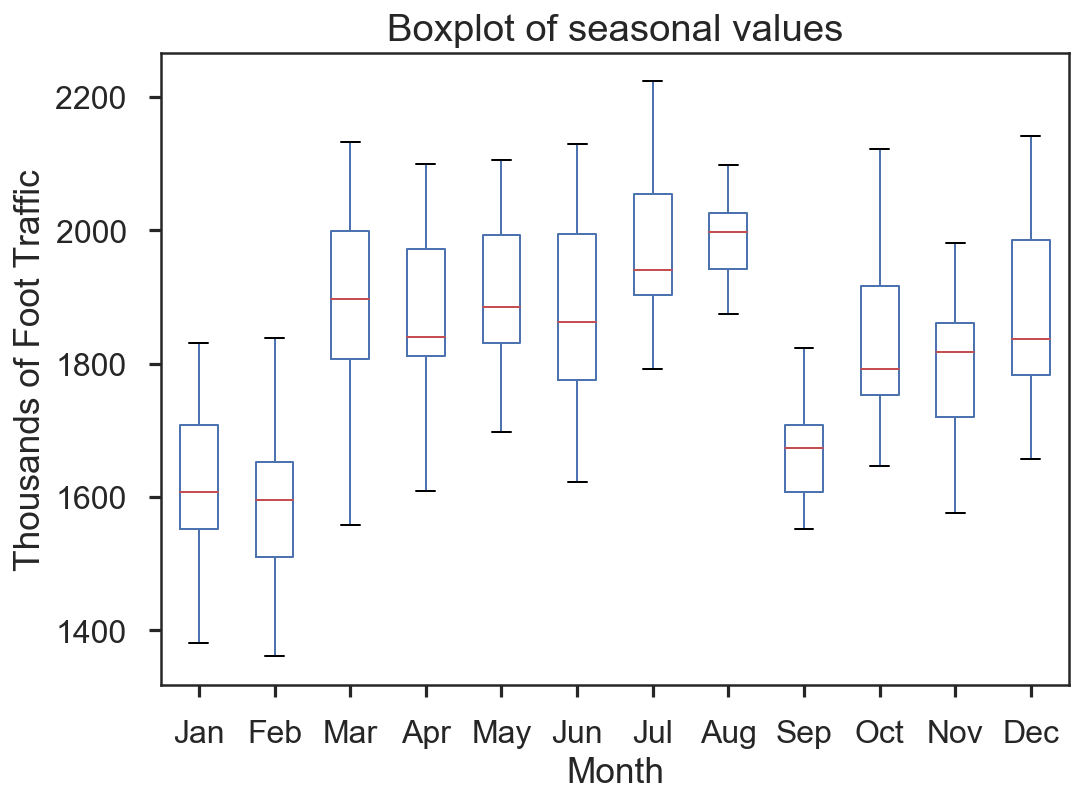

In [40]:
ts['Month'] = ts.index.strftime('%b')
ts['Year'] = ts.index.year

ts_piv = ts.pivot(index='Year', columns='Month', values="Ridership ('000)")

ts = ts.drop(['Month', 'Year'], axis=1)

# put the months in order
month_names = pd.date_range(start='2016-01-01', periods=12, freq='MS').strftime('%b')
ts_piv = ts_piv.reindex(columns=month_names)

# plot it
fig, ax = plt.subplots(figsize=(8, 6))
ts_piv.plot(ax=ax, kind='box');

ax.set_xlabel('Month');
ax.set_ylabel('Thousands of Foot Traffic');
ax.set_title('Boxplot of seasonal values');
ax.xaxis.set_ticks_position('bottom')
fig.tight_layout();

<div class="alert alert-info">
 $Differencing$
 </div>

In [41]:
# Take log of the series
ts['lnts'] = np.log(ts["Ridership ('000)"])
print(ts['lnts'].head(),"\n")
print(ts['lnts'].shape,"\n")

# Take first difference of the series
#ts_ln_diff = ts['lnts'].diff() - ts['lnts'].shift()
ts_ln_diff = ts['lnts'].diff()
ts_ln_diff = ts_ln_diff.dropna()
print(ts_ln_diff.head(),"\n")
print(ts_ln_diff.shape,"\n")

Month
1991-01-01   7.44362
1991-02-01   7.39054
1991-03-01   7.58717
1991-04-01   7.50200
1991-05-01   7.58831
Name: lnts, dtype: float64 

(159,) 

Month
1991-02-01   -0.05307
1991-03-01    0.19662
1991-04-01   -0.08516
1991-05-01    0.08630
1991-06-01   -0.05871
Name: lnts, dtype: float64 

(158,) 



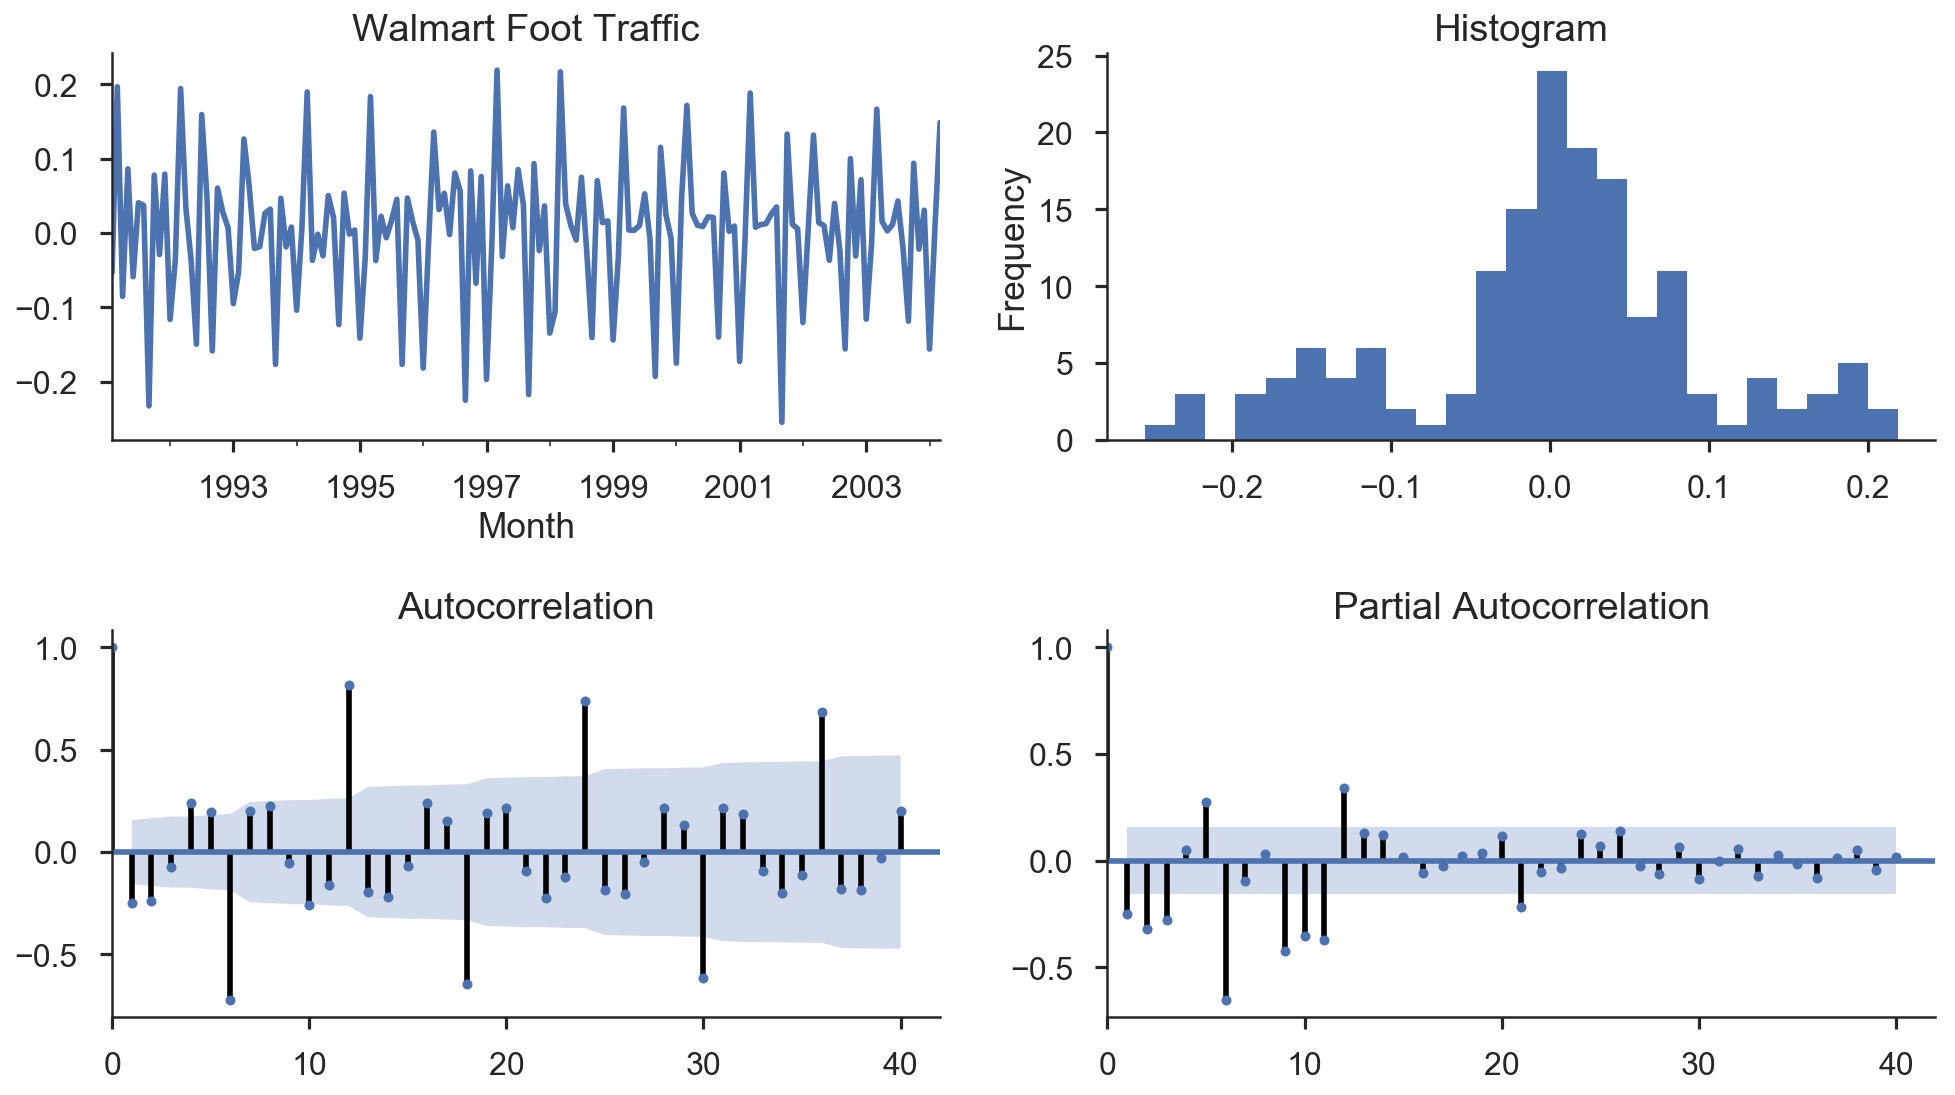

In [42]:
tsplot(ts_ln_diff, lags=40, title='Walmart Foot Traffic', figsize=(14, 8));

<div class="alert alert-success">
**Test for Heteroskedasticity: ** $Breakvar$

**Normality: ** $Jarque-Bera$

**Serial Correlation: ** $Ljung-Box$

</div>

In [43]:
def model_resid_stats(model_results,
                      het_method='breakvar',
                      norm_method='jarquebera',
                      sercor_method='ljungbox',
                      verbose=True,
                      ):
    '''More information about the statistics under the ARIMA parameters table, tests of standardized residuals:
    
    Test of heteroskedasticity
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity

    Test of normality (Default: Jarque-Bera)
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality

    Test of serial correlation (Default: Ljung-Box)
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_serial_correlation.html
    '''
    # Re-run the ARIMA model statistical tests, and more. To be used when selecting viable models.
    (het_stat, het_p) = model_results.test_heteroskedasticity(het_method)[0]
    norm_stat, norm_p, skew, kurtosis = model_results.test_normality(norm_method)[0]
    sercor_stat, sercor_p = model_results.test_serial_correlation(method=sercor_method)[0]
    sercor_stat = sercor_stat[-1] # last number for the largest lag
    sercor_p = sercor_p[-1] # last number for the largest lag

    # Run Durbin-Watson test on the standardized residuals.
    # The statistic is approximately equal to 2*(1-r), where r is the sample autocorrelation of the residuals.
    # Thus, for r == 0, indicating no serial correlation, the test statistic equals 2.
    # This statistic will always be between 0 and 4. The closer to 0 the statistic,
    # the more evidence for positive serial correlation. The closer to 4,
    # the more evidence for negative serial correlation.
    # Essentially, below 1 or above 3 is bad.
    dw_stat = sm.stats.stattools.durbin_watson(model_results.filter_results.standardized_forecasts_error[0, model_results.loglikelihood_burn:])

    # check whether roots are outside the unit circle (we want them to be);
    # will be True when AR is not used (i.e., AR order = 0)
    arroots_outside_unit_circle = np.all(np.abs(model_results.arroots) > 1)
    # will be True when MA is not used (i.e., MA order = 0)
    maroots_outside_unit_circle = np.all(np.abs(model_results.maroots) > 1)
    
    if verbose:
        print('Test heteroskedasticity of residuals ({}): stat={:.3f}, p={:.3f}'.format(het_method, het_stat, het_p));
        print('\nTest normality of residuals ({}): stat={:.3f}, p={:.3f}'.format(norm_method, norm_stat, norm_p));
        print('\nTest serial correlation of residuals ({}): stat={:.3f}, p={:.3f}'.format(sercor_method, sercor_stat, sercor_p));
        print('\nDurbin-Watson test on residuals: d={:.2f}\n\t(NB: 2 means no serial correlation, 0=pos, 4=neg)'.format(dw_stat))
        print('\nTest for all AR roots outside unit circle (>1): {}'.format(arroots_outside_unit_circle))
        print('\nTest for all MA roots outside unit circle (>1): {}'.format(maroots_outside_unit_circle))
    
    stat = {'het_method': het_method,
            'het_stat': het_stat,
            'het_p': het_p,
            'norm_method': norm_method,
            'norm_stat': norm_stat,
            'norm_p': norm_p,
            'skew': skew,
            'kurtosis': kurtosis,
            'sercor_method': sercor_method,
            'sercor_stat': sercor_stat,
            'sercor_p': sercor_p,
            'dw_stat': dw_stat,
            'arroots_outside_unit_circle': arroots_outside_unit_circle,
            'maroots_outside_unit_circle': maroots_outside_unit_circle,
            }
    return stat

$Breakvar$: test for heteroskedasticity of standardized residuals. The null hypothesis is of no heteroskedasticity. 
Two-sided: Null hypothesis is that the variance is not changing throughout the sample. 
Both that the sum-of-squares in the earlier subsample is not greater than the sum-of-squares in the 
later subsample and that the sum-of-squares in the later subsample is not greater than the sum-of-squares in the earlier subsample.

$Jarque–Bera$: test is a goodness-of-fit test of whether sample data have the skewness and kurtosis matching a normal distribution. Note that this test only works for a large enough number of data samples (>2000). The null hypothesis for the test is that the data is normally distributed; the alternate hypothesis is that the data does not come from a normal distribution.

$Ljung$-$Box$: test for no serial correlation of standardized residuals. Null hypothesis is no serial correlation.

$Durbin-Watson$: test on the standardized residuals.
The statistic is approximately equal to 2*(1-r), where r is the sample autocorrelation of the residuals.
Thus, for r == 0, indicating no serial correlation, the test statistic equals 2.
This statistic will always be between 0 and 4. The closer to 0 the statistic, the more evidence for positive serial    correlation. The closer to 4,
the more evidence for negative serial correlation.
Essentially, below 1 or above 3 is bad.

$AR$ & $MA$ $Roots$: must be outside the unit circle.

<div class = "alert alert-info">
$Grid$ $Search$
</div>

In [44]:
def model_gridsearch(ts,
                     p_min,
                     d_min,
                     q_min,
                     p_max,
                     d_max,
                     q_max,
                     sP_min,
                     sD_min,
                     sQ_min,
                     sP_max,
                     sD_max,
                     sQ_max,
                     trends,
                     s=None,
                     enforce_stationarity=True,
                     enforce_invertibility=True,
                     simple_differencing=False,
                     plot_diagnostics=False,
                     verbose=False,
                     filter_warnings=True,
                    ):
    '''Run grid search of SARIMAX models and save results.
    '''
    
    cols = ['p', 'd', 'q', 'sP', 'sD', 'sQ', 's', 'trend',
            'enforce_stationarity', 'enforce_invertibility', 'simple_differencing',
            'aic', 'bic',
            'het_p', 'norm_p', 'sercor_p', 'dw_stat',
            'arroots_gt_1', 'maroots_gt_1',
            'datetime_run']

    # Initialize a DataFrame to store the results
    df_results = pd.DataFrame(columns=cols)

    # # Initialize a DataFrame to store the results
    # results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
    #                            columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])

    mod_num=0
    for trend,p,d,q,sP,sD,sQ in itertools.product(trends,
                                                  range(p_min,p_max+1),
                                                  range(d_min,d_max+1),
                                                  range(q_min,q_max+1),
                                                  range(sP_min,sP_max+1),
                                                  range(sD_min,sD_max+1),
                                                  range(sQ_min,sQ_max+1),
                                                  ):
        # initialize to store results for this parameter set
        this_model = pd.DataFrame(index=[mod_num], columns=cols)

        if p==0 and d==0 and q==0:
            continue

        try:
            model = sm.tsa.SARIMAX(ts,
                                   trend=trend,
                                   order=(p, d, q),
                                   seasonal_order=(sP, sD, sQ, s),
                                   enforce_stationarity=enforce_stationarity,
                                   enforce_invertibility=enforce_invertibility,
                                   simple_differencing=simple_differencing,
                                  )
            
            if filter_warnings is True:
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore")
                    model_results = model.fit(disp=0)
            else:
                model_results = model.fit()

            if verbose:
                print(model_results.summary())

            if plot_diagnostics:
                model_results.plot_diagnostics();

            stat = model_resid_stats(model_results,
                                     verbose=verbose)

            this_model.loc[mod_num, 'p'] = p
            this_model.loc[mod_num, 'd'] = d
            this_model.loc[mod_num, 'q'] = q
            this_model.loc[mod_num, 'sP'] = sP
            this_model.loc[mod_num, 'sD'] = sD
            this_model.loc[mod_num, 'sQ'] = sQ
            this_model.loc[mod_num, 's'] = s
            this_model.loc[mod_num, 'trend'] = trend
            this_model.loc[mod_num, 'enforce_stationarity'] = enforce_stationarity
            this_model.loc[mod_num, 'enforce_invertibility'] = enforce_invertibility
            this_model.loc[mod_num, 'simple_differencing'] = simple_differencing

            this_model.loc[mod_num, 'aic'] = model_results.aic
            this_model.loc[mod_num, 'bic'] = model_results.bic

            # this_model.loc[mod_num, 'het_method'] = stat['het_method']
            # this_model.loc[mod_num, 'het_stat'] = stat['het_stat']
            this_model.loc[mod_num, 'het_p'] = stat['het_p']
            # this_model.loc[mod_num, 'norm_method'] = stat['norm_method']
            # this_model.loc[mod_num, 'norm_stat'] = stat['norm_stat']
            this_model.loc[mod_num, 'norm_p'] = stat['norm_p']
            # this_model.loc[mod_num, 'skew'] = stat['skew']
            # this_model.loc[mod_num, 'kurtosis'] = stat['kurtosis']
            # this_model.loc[mod_num, 'sercor_method'] = stat['sercor_method']
            # this_model.loc[mod_num, 'sercor_stat'] = stat['sercor_stat']
            this_model.loc[mod_num, 'sercor_p'] = stat['sercor_p']
            this_model.loc[mod_num, 'dw_stat'] = stat['dw_stat']
            this_model.loc[mod_num, 'arroots_gt_1'] = stat['arroots_outside_unit_circle']
            this_model.loc[mod_num, 'maroots_gt_1'] = stat['maroots_outside_unit_circle']

            this_model.loc[mod_num, 'datetime_run'] = pd.to_datetime('today').strftime('%Y-%m-%d %H:%M:%S')

            df_results = df_results.append(this_model)
            mod_num+=1
        except:
            continue
    return df_results

<div class = "alert alert-danger">
$Select$ $ARIMA$ $&$ $Seasonal$ $Paramters$ $for$ $Grid$ $Search$
</div>

In [45]:
# run model grid search
#ARIMA parameters

p_min = 0
d_min = 0
q_min = 0
p_max = 2
d_max = 1
q_max = 2

#Seasonal parameters

sP_min = 0
sD_min = 0
sQ_min = 0
sP_max = 1
sD_max = 1
sQ_max = 1

s=12

# trends=['n', 'c']
trends=['n']

enforce_stationarity=True
enforce_invertibility=True
simple_differencing=False

plot_diagnostics=False

verbose=False

df_results = model_gridsearch(ts_ln_diff,
                              p_min,
                              d_min,
                              q_min,
                              p_max,
                              d_max,
                              q_max,
                              sP_min,
                              sD_min,
                              sQ_min,
                              sP_max,
                              sD_max,
                              sQ_max,
                              trends,
                              s=s,
                              enforce_stationarity=enforce_stationarity,
                              enforce_invertibility=enforce_invertibility,
                              simple_differencing=simple_differencing,
                              plot_diagnostics=plot_diagnostics,
                              verbose=verbose,
                              )

<div class = "alert alert-info">
$Run$ $Grid$ $Search$
<div>

In [46]:
# choose a model

df_results.sort_values(by='bic').head(10)

,p,d,q,sP,sD,sQ,s,trend,enforce_stationarity,enforce_invertibility,simple_differencing,aic,bic,het_p,norm_p,sercor_p,dw_stat,arroots_gt_1,maroots_gt_1,datetime_run
5,0,0,1,1,0,1,12,n,True,True,False,-576.58445,-564.33407,0.01652,0.59922,0.78032,1.93088,True,True,2017-07-29 00:00:00
13,0,0,2,1,0,1,12,n,True,True,False,-576.26733,-560.95435,0.02225,0.65812,0.81315,1.98472,True,True,2017-07-29 00:00:00
35,1,0,0,1,0,1,12,n,True,True,False,-570.77951,-558.52913,0.01438,0.55145,0.56288,2.11730,True,True,2017-07-29 00:00:00
83,2,0,1,1,0,1,12,n,True,True,False,-576.77963,-558.40406,0.01600,0.32027,0.91169,2.03858,True,True,2017-07-29 00:00:00
47,1,0,2,1,0,1,12,n,True,True,False,-576.62651,-558.25094,0.02760,0.51789,0.89664,2.05688,True,True,2017-07-29 00:00:00
75,2,0,0,1,0,1,12,n,True,True,False,-573.24419,-557.93121,0.01231,0.65161,0.77836,2.02519,True,True,2017-07-29 00:00:00
3,0,0,1,0,1,1,12,n,True,True,False,-551.88301,-542.69523,0.00514,0.92866,0.97456,1.94960,True,True,2017-07-29 00:00:00
107,2,1,2,1,0,1,12,n,True,True,False,-562.04708,-540.60892,0.00388,0.53364,0.83220,2.01701,True,True,2017-07-29 00:00:00
39,1,0,1,0,1,1,12,n,True,True,False,-552.16264,-539.91226,0.00888,0.81260,0.99095,2.06335,True,True,2017-07-29 00:00:00
11,0,0,2,0,1,1,12,n,True,True,False,-550.85269,-538.60231,0.00752,0.92013,0.97656,1.98800,True,True,2017-07-29 00:00:00


$Breakvar$: test for heteroskedasticity of standardized residuals. The null hypothesis is of no heteroskedasticity. 
Two-sided: Null hypothesis is that the variance is not changing throughout the sample. 
Both that the sum-of-squares in the earlier subsample is not greater than the sum-of-squares in the 
later subsample and that the sum-of-squares in the later subsample is not greater than the sum-of-squares in the earlier subsample.

$Jarque–Bera$: test is a goodness-of-fit test of whether sample data have the skewness and kurtosis matching a normal distribution. Note that this test only works for a large enough number of data samples (>2000). The null hypothesis for the test is that the data is normally distributed; the alternate hypothesis is that the data does not come from a normal distribution.

$Ljung$-$Box$: test for no serial correlation of standardized residuals. Null hypothesis is no serial correlation.  **H0**: The data are independently distributed (i.e. the correlations in the population from which the sample is taken are 0, so that any observed correlations in the data result from randomness of the sampling process).
**Ha**: The data are not independently distributed; they exhibit serial correlation.

$Durbin-Watson$: test on the standardized residuals.
The statistic is approximately equal to 2*(1-r), where r is the sample autocorrelation of the residuals.
Thus, for r == 0, indicating no serial correlation, the test statistic equals 2.
This statistic will always be between 0 and 4. The closer to 0 the statistic, the more evidence for positive serial    correlation. The closer to 4,
the more evidence for negative serial correlation.
Essentially, below 1 or above 3 is bad.

$AR$ & $MA$ $Roots$: must be outside the unit circle.

<div class = "alert alert-info">
$Seasonal$ $ARIMA$ $Model$ $for$ $Forecasting$
</div>

In [47]:
# Selected Grid Search Model
mod = sm.tsa.statespace.SARIMAX(ts_ln_diff, order=(0,0,2), seasonal_order=(1,0,1,12), simple_differencing=True)
sarima_fit1 = mod.fit()
print(sarima_fit1.summary())

                                 Statespace Model Results                                 
Dep. Variable:                               lnts   No. Observations:                  158
Model:             SARIMAX(0, 0, 2)x(1, 0, 1, 12)   Log Likelihood                 293.134
Date:                            Sat, 29 Jul 2017   AIC                           -576.267
Time:                                    15:52:57   BIC                           -560.954
Sample:                                02-01-1991   HQIC                          -570.049
                                     - 03-01-2004                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4298      0.078     -5.477      0.000      -0.584      -0.276
ma.L2         -0.1240      0.076   

<div class = "alert alert-info">
$ARIMA$ $Model$ $for$ $Forecasting$
</div>

In [ ]:
#Model Estimation

# Fit the model
arima200 = sm.tsa.SARIMAX(ts_train, order=(2,0,0))
model_results = arima200.fit()
model_results.summary()

<div class = "alert alert-info">
$Model$ $Disgnostic$
</div>

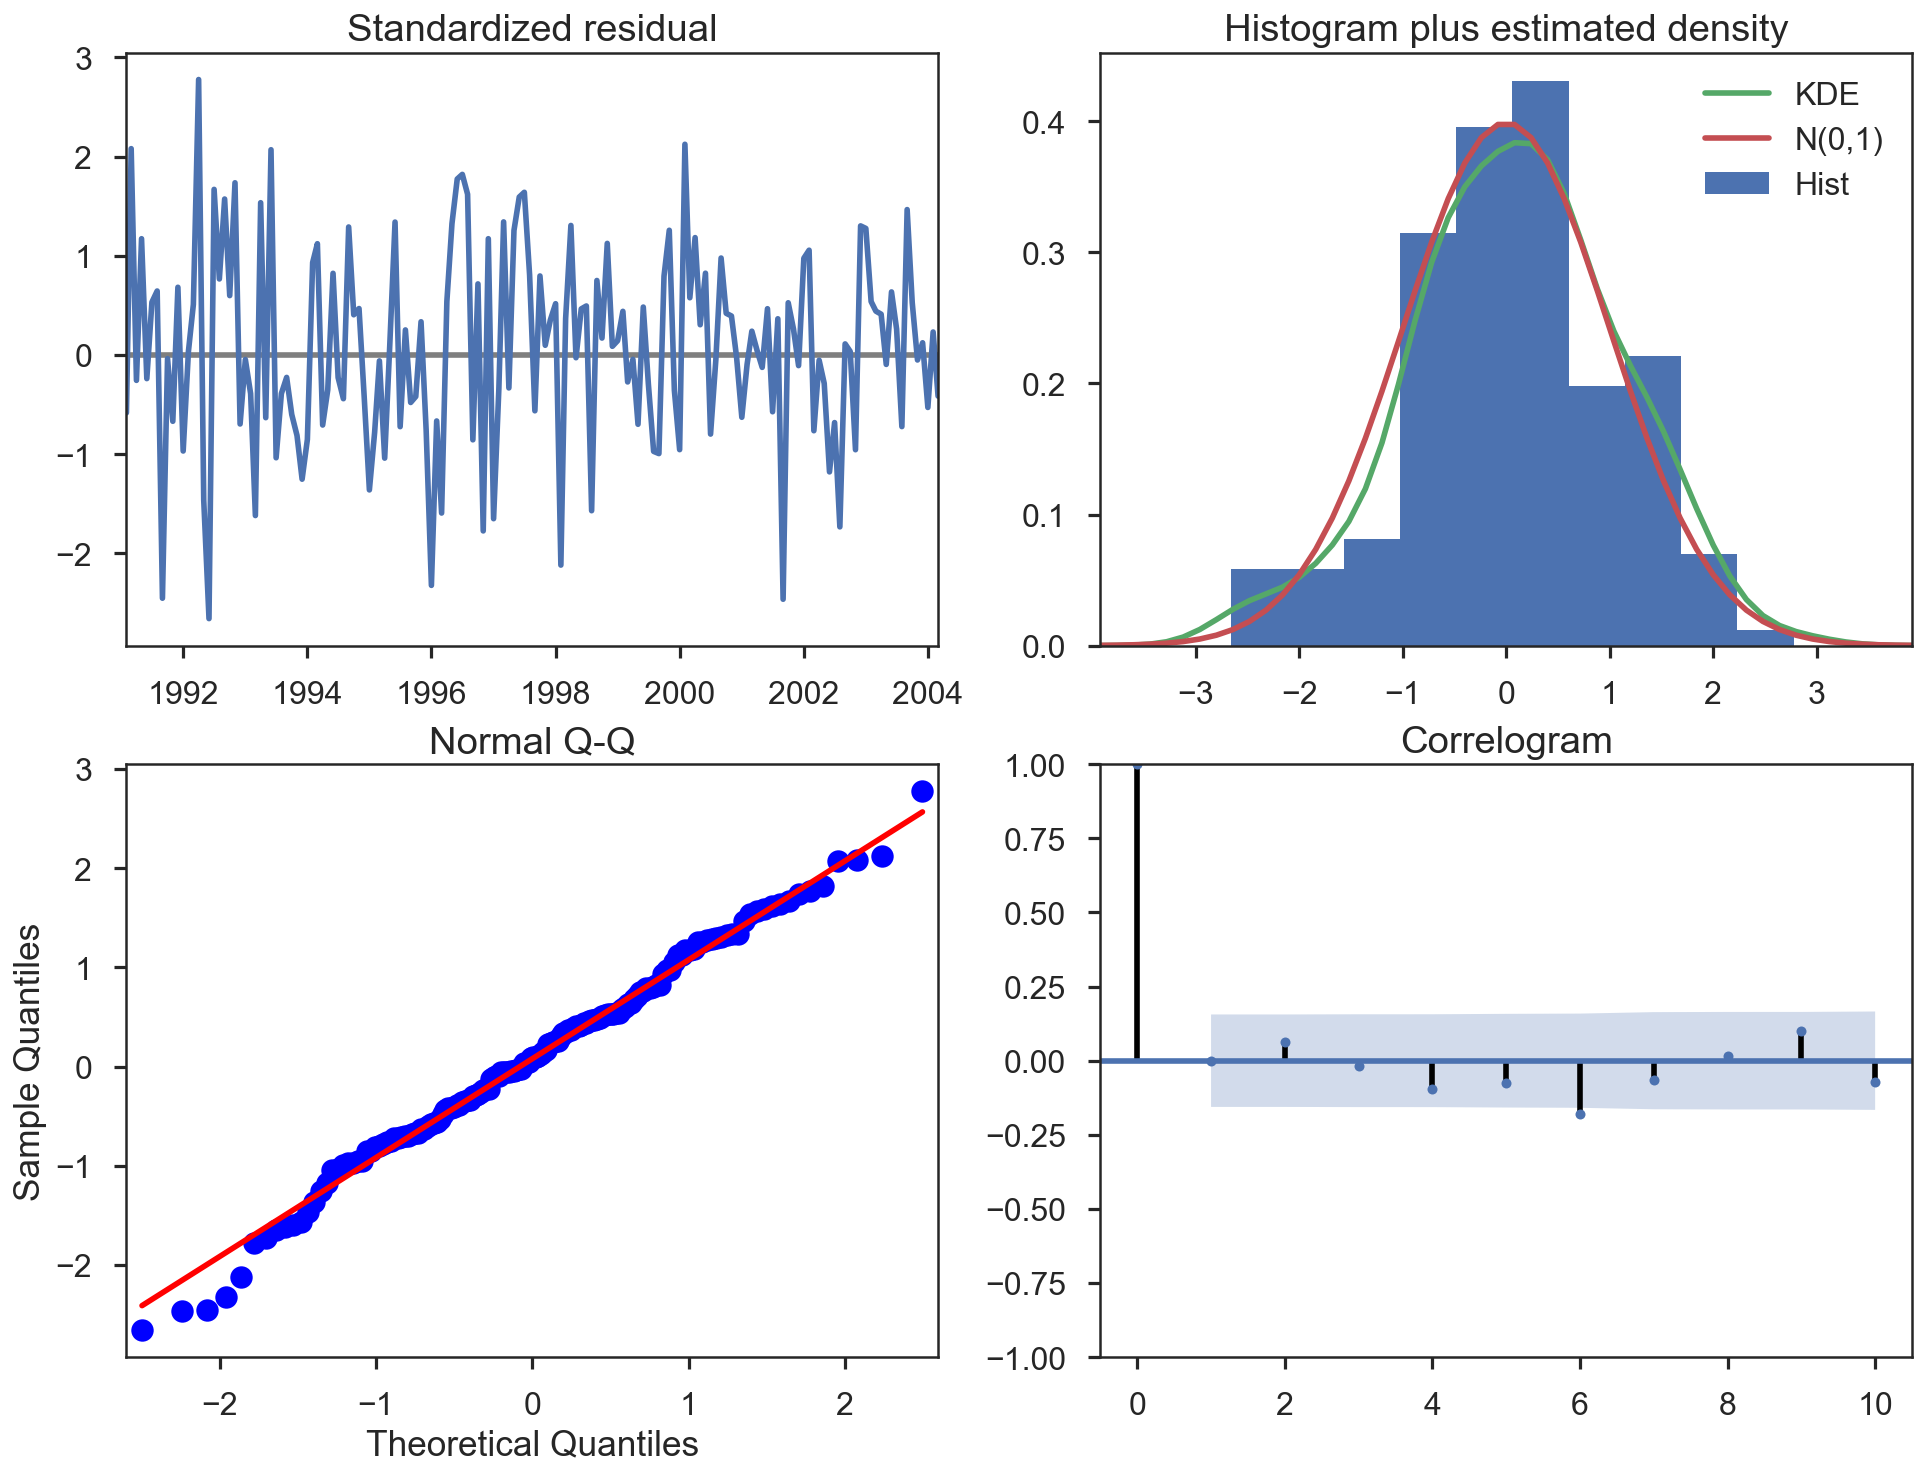

In [48]:
# Model Diagnostic

sarima_fit1.plot_diagnostics(figsize=(16, 12));

<div class = "alert alert-success">

$Model$ $Performance$ $Evaluation$ (in-sample fit)

</div>

In [51]:
n_sample = ts_ln_diff.shape[0]

# Create a training sample and testing sample before analyzing the series

n_train=int(0.95*n_sample)+1
n_forecast=n_sample-n_train
#ts_df
ts_train = ts_ln_diff.iloc[:n_train]#['value']
ts_test = ts_ln_diff.iloc[n_train:]#['value']
print(ts_train.shape)
print(ts_test.shape)
print("Training Series:", "\n", ts_train.tail(), "\n")
print("Testing Series:", "\n", ts_test.head())


(151,)
(7,)
Training Series: 
 Month
2003-04-01    0.01557
2003-05-01    0.00286
2003-06-01    0.01169
2003-07-01    0.04305
2003-08-01   -0.02228
Name: lnts, dtype: float64 

Testing Series: 
 Month
2003-09-01   -0.11849
2003-10-01    0.09386
2003-11-01   -0.02164
2003-12-01    0.03065
2004-01-01   -0.15598
Name: lnts, dtype: float64


##### Adjust time if needed for model
```bash
start=pred_begin.strftime('%Y-%m-%d %H:%M:%S')

start=pred_begin.strftime('%Y-%m-%d')
```

<div class = "alert alert-danger">

$Seasonal$ $Model$ 

</div>

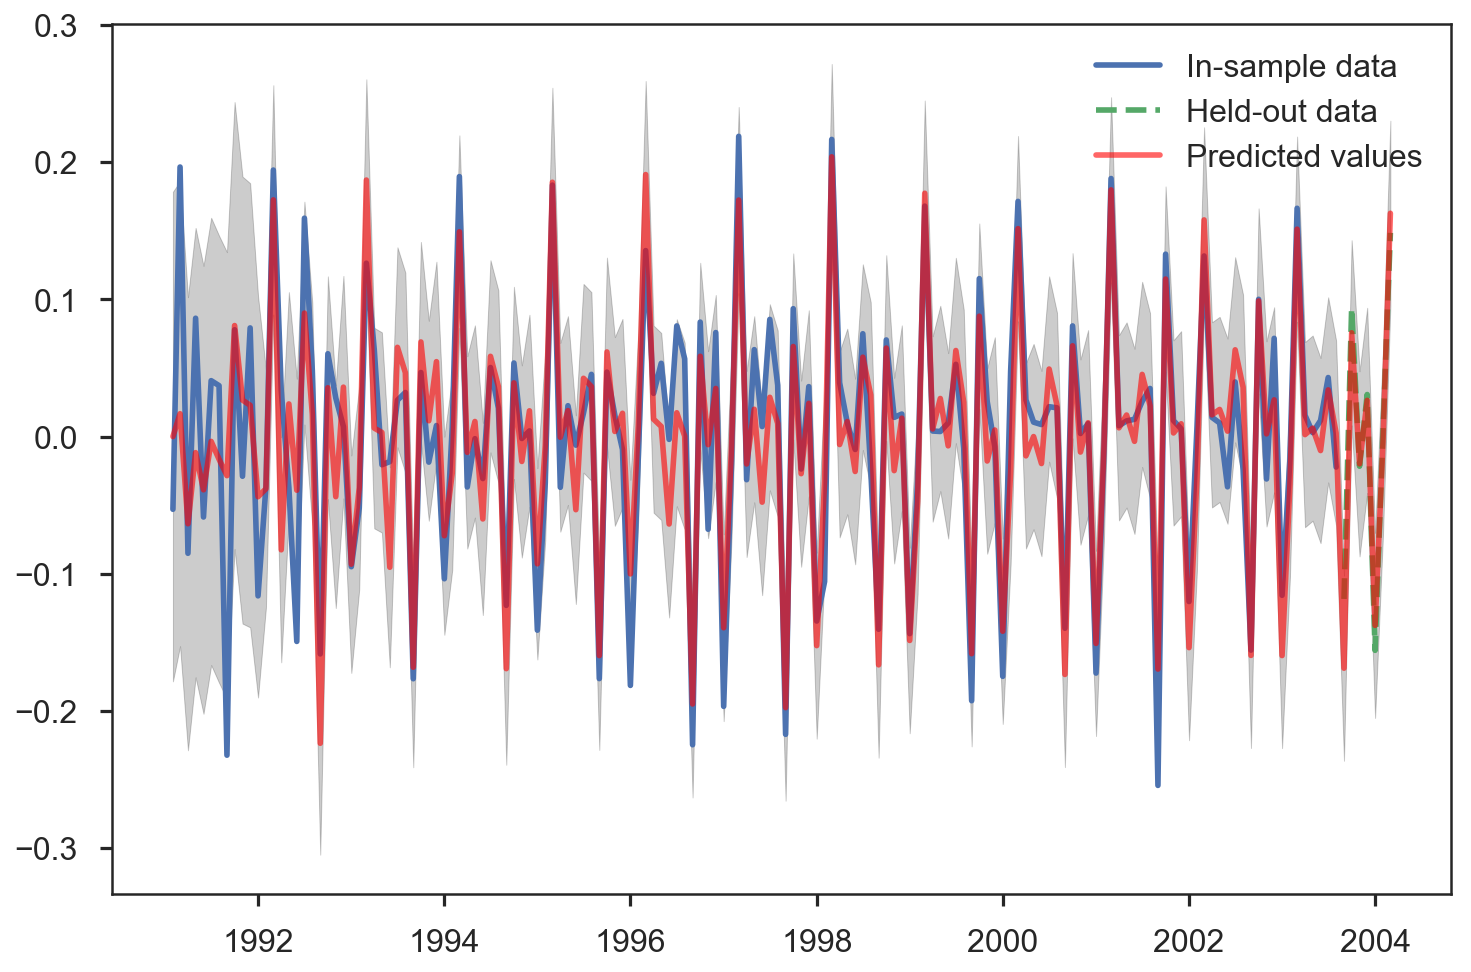

In [53]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(ts_train, label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(ts_test, label='Held-out data', linestyle='--')

# yes DatetimeIndex
pred_begin = ts_train.index[sarima_fit1.loglikelihood_burn]
pred_end = ts_test.index[-1]
pred = sarima_fit1.get_prediction(start=pred_begin.strftime('%Y-%m-%d %H:%M:%S'),
                                    end=pred_end.strftime('%Y-%m-%d %H:%M:%S'))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax1.legend(loc='best');

<div class = "alert alert-danger">

$ARIMA$ $Model$ 

</div>

In [ ]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(ts_train, label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(ts_test, label='Held-out data', linestyle='--')

# yes DatetimeIndex
pred_begin = ts_train.index[model_results.loglikelihood_burn]
pred_end = ts_test.index[-1]
pred = model_results.get_prediction(start=pred_begin.strftime('%Y-%m-%d %H:%M:%S'),
                                    end=pred_end.strftime('%Y-%m-%d %H:%M:%S'))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax1.legend(loc='best');

<div class = "alert alert-success">

$Root$ $Mean$ $Square$ $Error$, $Mean$ $Absolute$ $Percent$ $Error$, $Mean$ $Absolute$ $Scaled$ $Error$
</div>

In [55]:
def get_rmse(y, y_hat):
    '''Root Mean Square Error
    https://en.wikipedia.org/wiki/Root-mean-square_deviation
    '''
    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

def get_mape(y, y_hat):
    '''Mean Absolute Percent Error
    https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    '''
    perc_err = (100*(y - y_hat))/y
    return np.mean(abs(perc_err))

def get_mase(y, y_hat):
    '''Mean Absolute Scaled Error
    https://en.wikipedia.org/wiki/Mean_absolute_scaled_error
    '''
    abs_err = abs(y - y_hat)
    dsum=sum(abs(y[1:] - y_hat[1:]))
    t = len(y)
    denom = (1/(t - 1))* dsum
    return np.mean(abs_err/denom)

<div class = "alert alert-success">
$Training$ $Set$ $Metrics$
</div>

In [56]:
rmse = get_rmse(ts_train, pred_mean.loc[ts_train.index])
print("RMSE: ", rmse)

mape = get_mape(ts_train, pred_mean.loc[ts_train.index])
print("MAPE: ", mape)

mase = get_mase(ts_train, pred_mean.loc[ts_train.index])
print("MASE: ", mase)

RMSE:  0.0438119616911
MAPE:  136.50048471178764
MASE:  1.004335283807183


<div class = "alert alert-success">
$Test$ $Set$ $Metrics$
</div>

In [57]:
rmse = get_rmse(ts_test, pred_mean.loc[ts_test.index])
print(f"RMSE: {rmse:.4f}")

mape = get_mape(ts_test, pred_mean.loc[ts_test.index])
print(f"MAPE: {mape:.4f}")

mase = get_mase(ts_test, pred_mean.loc[ts_test.index])
print(f"MASE: {mase:.4f}")

RMSE: 0.0224
MAPE: 47.2684
MASE: 1.5268


In [61]:
report = model_resid_stats(sarima_fit1,
                      het_method='breakvar',
                      norm_method='jarquebera',
                      sercor_method='ljungbox',
                      verbose=True,
                      )
report

Test heteroskedasticity of residuals (breakvar): stat=0.529, p=0.022

Test normality of residuals (jarquebera): stat=0.837, p=0.658

Test serial correlation of residuals (ljungbox): stat=31.974, p=0.813

Durbin-Watson test on residuals: d=1.98
	(NB: 2 means no serial correlation, 0=pos, 4=neg)

Test for all AR roots outside unit circle (>1): True

Test for all MA roots outside unit circle (>1): True


{'arroots_outside_unit_circle': True,
 'dw_stat': 1.9847223849761757,
 'het_method': 'breakvar',
 'het_p': 0.022245342054415085,
 'het_stat': 0.52927574479905304,
 'kurtosis': 3.0750101100088711,
 'maroots_outside_unit_circle': True,
 'norm_method': 'jarquebera',
 'norm_p': 0.6581175237283603,
 'norm_stat': 0.83674351223065835,
 'sercor_method': 'ljungbox',
 'sercor_p': 0.8131461021302383,
 'sercor_stat': 31.974287100334561,
 'skew': -0.17426543241223375}

<div  class= "alert alert-danger">

**ARIMA Grid Search** $Demonstration$

</div>

In [ ]:
# load time series
liquor = pd.read_csv('data/liquor.csv', header=0, index_col=0, parse_dates=[0])

# Keey only the data from the last 10 years or so
liquor = liquor.ix['2007':'2016']

In [ ]:
# plot
tsplot(liquor['Value'], title='Liquor Sales (in millions of dollars), 2007-2016', lags=40);

In [ ]:
# Test stationarity

test_stationarity(liquor['Value'])

In [ ]:
# Take first difference of the series
test_stationarity(liquor['Value'].diff().dropna())

In [ ]:
# Take log of the series
liquor['lnliquor'] = np.log(liquor)

test_stationarity(liquor['lnliquor'])

In [ ]:
# Take first difference of the log series
liquor_ln_diff = liquor['lnliquor'].diff()
liquor_ln_diff = liquor_ln_diff.dropna()

test_stationarity(liquor_ln_diff)

In [ ]:
# run model grid search
#ARIMA parameters

p_min = 0
d_min = 0
q_min = 0
p_max = 2
d_max = 1
q_max = 2

#Seasonal parameters

sP_min = 0
sD_min = 0
sQ_min = 0
sP_max = 1
sD_max = 1
sQ_max = 1

s=12

# trends=['n', 'c']
trends=['n']

enforce_stationarity=True
enforce_invertibility=True
simple_differencing=False

plot_diagnostics=False

verbose=False

df_results = model_gridsearch(liquor['Value'],
                              p_min,
                              d_min,
                              q_min,
                              p_max,
                              d_max,
                              q_max,
                              sP_min,
                              sD_min,
                              sQ_min,
                              sP_max,
                              sD_max,
                              sQ_max,
                              trends,
                              s=s,
                              enforce_stationarity=enforce_stationarity,
                              enforce_invertibility=enforce_invertibility,
                              simple_differencing=simple_differencing,
                              plot_diagnostics=plot_diagnostics,
                              verbose=verbose,
                              )

In [ ]:
# choose a model

df_results.sort_values(by='bic').head(10)

### References

#### Jupyter notebooks, presentations, blog posts

- Example notebooks using SARIMAX models:
    - SARIMAX introduction
        - http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html
    - Model selection, missing data
        - http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_internet.html
- "Time series analysis and forecasting with statsmodels" presentation, by a statsmodels lead contributor
    - https://josef-pkt.github.io/pages/slides/slides_forecasting.slides.html
- Time series analysis using Pandas and statsmodels, by a statsmodels lead contributor
    - https://tomaugspurger.github.io/modern-7-timeseries.html
- Time series analysis using Pandas and statsmodels
    - https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
- Simple example of SARIMA forecast (based on the analyticsvidhya.com post)
    - http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/


#### Free textbooks available online

- Forecasting: principles and practice (free textbook, with R code)
    - https://www.otexts.org/fpp/
- Time Series Analysis and Its Applications: With R Examples (Shumway & Stoffer, EZ time series edition)
    - http://www.stat.pitt.edu/stoffer/tsa4/

